# ResNet9

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from utils import run

### CIFAR10 Dataset

In [2]:
# Training batch size
batch_size = 256

# Train transformation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified


### ResNet Model

In [3]:
def conv_bn(ch_in, ch_out, pool=False):
    layers = [
        nn.Conv2d(ch_in, ch_out, kernel_size=3,
                  padding=1, stride=1, bias=False),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(conv_bn(ch, ch), conv_bn(ch, ch))

    def forward(self, x):
        return self.net(x) + x


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.net = nn.Sequential(
            conv_bn(3, 64),
            conv_bn(64, 128, pool=True),
            ResidualBlock(128),

            conv_bn(128, 256, pool=True),
            conv_bn(256, 512, pool=True),
            ResidualBlock(512),

            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        return self.net(x)


In [4]:
# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = ResNet().to(device)
print(model)

Using cuda device
ResNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ResidualBlock(
      (net): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


 =============== Epoch 1 ===============
 Train accuracy: 39.7%, Avg loss: 1.865037
 Test accuracy: 51.3%, Avg loss: 1.477403

 =============== Epoch 2 ===============
 Train accuracy: 54.9%, Avg loss: 1.420954
 Test accuracy: 56.0%, Avg loss: 1.578295

 =============== Epoch 3 ===============
 Train accuracy: 63.9%, Avg loss: 1.169377
 Test accuracy: 69.5%, Avg loss: 0.893781

 =============== Epoch 4 ===============
 Train accuracy: 72.7%, Avg loss: 0.846447
 Test accuracy: 70.9%, Avg loss: 0.906096

 =============== Epoch 5 ===============
 Train accuracy: 77.8%, Avg loss: 0.669921
 Test accuracy: 74.7%, Avg loss: 0.786686

 =============== Epoch 6 ===============
 Train accuracy: 81.3%, Avg loss: 0.552941
 Test accuracy: 78.0%, Avg loss: 0.679884

 =============== Epoch 7 ===============
 Train accuracy: 83.1%, Avg loss: 0.494390
 Test accuracy: 80.9%, Avg loss: 0.577752

 =============== Epoch 8 ===============
 Train accuracy: 85.5%, Avg loss: 0.427091
 Test accuracy: 81.9%, Avg

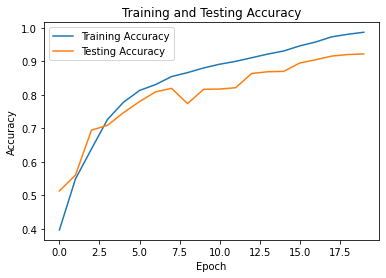

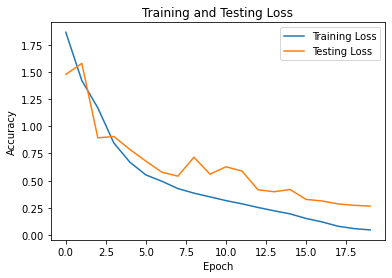

Best test accuracy: 92.21


In [5]:
# Total training epochs
epochs = 20

# Loss function
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    0.1,
    epochs=epochs,
    steps_per_epoch=len(train_dataloader),
)

run(model, epochs, optimizer, loss_fn, train_dataloader=train_dataloader,
    test_dataloader=test_dataloader, scheduler=scheduler)